In [55]:

import pandas as pd

#Read sentences from a text file
def read_file(filename):
    with open(filename, 'r') as f:
        lines = [x.strip() for x in f.readlines()]
        return lines

# load sentences and slot labels into a dataframe
sentences = read_file("slotData/snips_sentences_subset.txt")
slot_labels = read_file("slotData/snips_slot_labels_subset.txt")

df = pd.DataFrame(list(zip(sentences, slot_labels)), columns =['sentences', 'slot_labels']) 
df.head()

,sentences,slot_labels
0,Add another song to the Cita RomÃ¡ntica playlist,O O B-music_item O O B-playlist I-playlist O
1,add clem burke in my playlist Pre-Party R&B Jams,O B-artist I-artist O B-playlist_owner O B-pla...
2,Add Live from Aragon Ballroom to Trapeo,O B-entity_name I-entity_name I-entity_name I-...
3,add Unite and Win to my night out,O B-entity_name I-entity_name I-entity_name O ...
4,Add track to my Digster Future Hits,O B-music_item O B-playlist_owner B-playlist I...


In [8]:

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# store seeds
TEST_SPLIT = 0.2
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(df['sentences'], df['slot_labels'], 
                                                    test_size = TEST_SPLIT, random_state = RANDOM_STATE)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6299,) (1575,) (6299,) (1575,)


In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils

# we know max number of words in dataset
MAX_NUM_WORDS = 7501
OOV_TOKEN = "<UNK>"

# Initialize Tokenizers for words and slot labels
# Is filtering out nothing the right thing to do?
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters = '', lower = False, oov_token = OOV_TOKEN)
tokenizer.fit_on_texts(list(X_train))

y_tokenizer = Tokenizer(filters = '', lower = False)
y_tokenizer.fit_on_texts(list(y_train))

# Convert text to sequences
X_seq = tokenizer.texts_to_sequences(list(X_train))
X_test_seq = tokenizer.texts_to_sequences(list(X_test))

y_seq = y_tokenizer.texts_to_sequences(list(y_train))
y_test_seq = y_tokenizer.texts_to_sequences(list(y_test))

# make the max seq length the 99th percentile of the lengths
lengths = [len(c.split()) for c in X_train]
MAX_SEQ_LEN = int(np.percentile(lengths, 99))

# Pad the sequences
X_train_padded = pad_sequences(X_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
X_test_padded = pad_sequences(X_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

y_train_padded = pad_sequences(y_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
y_test_padded = pad_sequences(y_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

# Convert labels to one-hot vectors
# There are 58 unique slot labels
train_labels_encoded = utils.to_categorical(y_train_padded)
test_labels_encoded = utils.to_categorical(y_test_padded)
print(train_labels_encoded.shape, test_labels_encoded.shape)

#Reshape the input for Bi-LSTM
train_sequences = np.reshape(X_train_padded, (X_train_padded.shape[0], X_train_padded.shape[1], 1))
test_sequences = np.reshape(X_test_padded, (X_test_padded.shape[0], X_test_padded.shape[1], 1))
print(X_train_padded.shape, X_test_padded.shape)

(6299, 19, 58) (1575, 19, 58)
(6299, 19) (1575, 19)


In [32]:
# create a dictionary, where each word indexes its embedding

embeddings_index={}

with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [33]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()

num_words = MAX_NUM_WORDS+1
embedding_dim=len(embeddings_index['the'])

# just populate with random values in case there is a missing value
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))

# word encodings are sorted [1..n]
# loop through all (word, encoding) pairs and place it in the embedding matrix
for word, i in tokenizer.word_index.items():
    if i >= MAX_NUM_WORDS:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed, Dropout

NUM_UNITS = 128
Y_VOCAB_SIZE = len(y_tokenizer.word_index) + 1


#Define a Bi-LSTM model
bilstm_model = Sequential()
embedding_layer = Embedding(num_words, embedding_dim, input_length=MAX_SEQ_LEN, embeddings_initializer=Constant(embedding_matrix), trainable=False)
# Embedding(input_dim = MAX_NUM_WORDS, output_dim = EMBEDDING_DIM, input_length = MAX_SEQ_LEN)
bilstm_model.add(embedding_layer)
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(NUM_UNITS, activation='relu', return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(NUM_UNITS, activation='relu', return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(TimeDistributed(Dense(Y_VOCAB_SIZE, activation='softmax')))

#Compile the model
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

bilstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 100)           750200    
                                                                 
 dropout_9 (Dropout)         (None, 19, 100)           0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 19, 256)           234496    
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 19, 256)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 19, 256)           394240    
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 19, 256)          

In [38]:
# Fit the model on training data
history = bilstm_model.fit(train_sequences, train_labels_encoded, batch_size = 64, epochs = 8, validation_data=(test_sequences, test_labels_encoded))

Epoch 1/8
99/99 [==============================] - 22s 128ms/step - loss: 1.2727 - accuracy: 0.7372 - val_loss: 0.7631 - val_accuracy: 0.7944
Epoch 2/8
99/99 [==============================] - 12s 120ms/step - loss: 0.6154 - accuracy: 0.8355 - val_loss: 0.3722 - val_accuracy: 0.8941
Epoch 3/8
99/99 [==============================] - 12s 120ms/step - loss: 0.3763 - accuracy: 0.8902 - val_loss: 0.2421 - val_accuracy: 0.9265
Epoch 4/8
99/99 [==============================] - 12s 122ms/step - loss: 0.2834 - accuracy: 0.9157 - val_loss: 0.1967 - val_accuracy: 0.9402
Epoch 5/8
99/99 [==============================] - 12s 120ms/step - loss: 0.2297 - accuracy: 0.9291 - val_loss: 0.1555 - val_accuracy: 0.9520
Epoch 6/8
99/99 [==============================] - 12s 122ms/step - loss: 0.1910 - accuracy: 0.9409 - val_loss: 0.1408 - val_accuracy: 0.9569
Epoch 7/8
99/99 [==============================] - 12s 120ms/step - loss: 0.1674 - accuracy: 0.9469 - val_loss: 0.1327 - val_accuracy: 0.9583
Epoch 

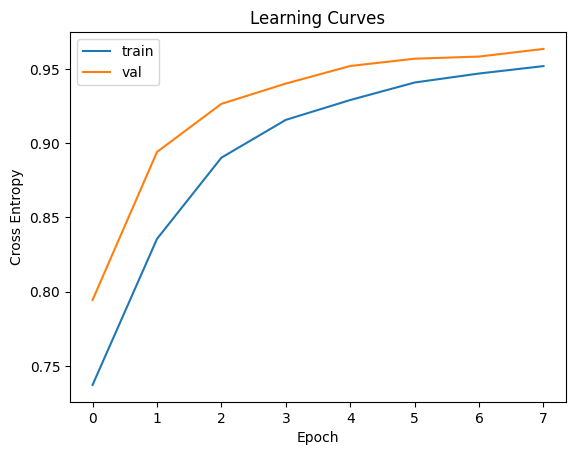

In [72]:
from matplotlib import pyplot

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [73]:
#Evaluate the model performance on test data
bilstm_score = bilstm_model.evaluate(test_sequences, test_labels_encoded, batch_size = 32)

50/50 [==============================] - 1s 15ms/step - loss: 0.1166 - accuracy: 0.9635


In [74]:
import pickle

# save the model
bilstm_model.save('models/slotLabelling.keras')

with open('./slotLabelModel/tokenizer.pkl','wb') as file:
  pickle.dump(tokenizer, file)

with open('./slotLabelModel/label_list.pkl','wb') as file:
  label_list = list(y_tokenizer.word_index.keys())
  pickle.dump(label_list, file)

with open('./slotLabelModel/index_list.pkl','wb') as file:
  index_list = list(y_tokenizer.word_index.values())
  pickle.dump(index_list, file)

with open('./slotLabelModel/max_seq_length.pkl','wb') as file:
  pickle.dump(MAX_SEQ_LEN, file)

In [5]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# a class that takes in encoding/model components and returns the intent of a given text
class SlotLabeller:
    def __init__(self, model, tokenizer, label_list, index_list, max_seq_len):
        self.model = model
        self.tokenizer = tokenizer
        self.label_list = label_list
        self.index_list = index_list
        self.max_seq_len = max_seq_len

    def fill_slots(self, text):
        self.text = [text]
        self.input_seq = self.tokenizer.texts_to_sequences(self.text)
        self.sequence = pad_sequences(self.input_seq, maxlen=self.max_seq_len, padding='post')

        prediction = self.model.predict(self.sequence)
        return [self.label_list[self.index_list.index(j)] for j in [np.argmax(x) for x in prediction[0][:]] if j in self.index_list]
    

In [6]:
import pickle
from keras.models import load_model

# load the slot labelling model
loaded_model = load_model('models/slotLabelling.keras')

# load the necessary supllementary components
with open('./slotLabelModel/tokenizer.pkl','rb') as file:
    slot_tokenizer = pickle.load(file)

with open('./slotLabelModel/label_list.pkl','rb') as file:
    slot_label_list = pickle.load(file)

with open('./slotLabelModel/index_list.pkl','rb') as file:
    slot_index_list = pickle.load(file)

with open('./slotLabelModel/max_seq_length.pkl','rb') as file:
    slot_max_seq_length = pickle.load(file)

In [7]:
# BEHOLD: THE SLOT LABELLER
slotLabeller = SlotLabeller(loaded_model, slot_tokenizer, slot_label_list, slot_index_list, slot_max_seq_length)

utterance = "I want to order a pizza"
slotLabeller.fill_slots(utterance)

1/1 [==============================] - 1s 682ms/step


['O', 'O', 'O', 'O', 'O', 'B-restaurant_type']